In [1]:
### GMOSS_HealpixSpectra.ipynb
##
## Generate GMOSS spectra towards 3072 Healpix directions
## Using parameters file in GMOSS_params_allpix.txt
##
## Based on code in GMOSS_8aug17.c
##
## Uses a freq_array defined in section below as the frequency axis

import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import healpy as hp
import aipy as a
import scipy.constants
import scipy.integrate
import scipy.io
import pickle
import datetime

PI = np.pi

FILE_PARAMS = 'GMOSS_params_allpix.txt'


In [2]:
### Define frequency array
###
freq_array = np.linspace(40.0,230.0,num=191,endpoint=True,dtype=float)  # MHz

print("Number of frequencies: ",len(freq_array))

freq_GHz = freq_array/1000.0
print(" Frequency array ends: ",freq_GHz[0],freq_GHz[1],".....",freq_GHz[-2],freq_GHz[-1]," GHz. ")

Number of frequencies:  191
 Frequency array ends:  0.04 0.041 ..... 0.229 0.23  GHz. 


In [3]:
### Define Nested Healpix sky with nside 16 (3072 pixels)
###
NSIDE = 16   # hardcoded to conform to the content of FILE_PARAMS

npix = hp.pixelfunc.nside2npix(NSIDE)
resol = hp.pixelfunc.nside2resol(NSIDE,arcmin=True)
print("Generate spectra at healpix with nside, npix, resol (arcmin): ",NSIDE, npix, resol)

Generate spectra at healpix with nside, npix, resol (arcmin):  16 3072 219.87113035631398


In [4]:
### Read in the parameter file
###
flag = []
norm_param = []
alpha1_param = []
dalpha_param = []
nubrk_param = []
Tx_param = []
Te_param = []
nut_param = []

with open(FILE_PARAMS) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if row != []:
            row = row[0].split()
            
            flag.append(int(row[1]))
            norm_param.append(float(row[2]))
            alpha1_param.append(float(row[3]))
            dalpha_param.append(float(row[4]))
            nubrk_param.append(float(row[5]))
            Tx_param.append(float(row[6]))
            Te_param.append(float(row[7]))
            nut_param.append(float(row[8]))

print("Got parameters in ",len(Tx_param)," pixels.")

Got parameters in  3072  pixels.


In [5]:
## Iterate over sky pixels, computing the entire spectrum at each sky position

import warnings
warnings.filterwarnings("ignore")

band_definition = [[ 41.430528,  82.861056], \
       [ 57.5424  , 115.0848  ], \
       [ 79.92    , 159.84    ], \
       [111.      , 222.      ]]

GSPAN = 100.0  # defines a factor by which the range of integration is expanded beyond required boundary

q_e = 1.6e-19
Bmag = 1e-9  # Tesla == 10 micro-Gauss
sin_alph = 1.0
m_e = 9.1e-31
cvel = scipy.constants.c
scale_gam_nu = (3.0*q_e*Bmag*sin_alph)/(4.0*PI*m_e*cvel)

# Return value of polynomial
func_poly = lambda p, x    : (np.polyval(p,x))

def modbessik2(u):  # Modified Bessel Fn of second kind 
                    # for non-negative real fractional order for real positive argument
                    # Takes numpy arrays as inputs

    xnu = 5.0/3.0  # fractional order
    uu = np.where ((u<0.01),0.01,u)
    arg = np.reciprocal(uu) # argument
    bk = scipy.special.kve(xnu, arg, out=None)
    xrk = np.divide(bk,np.exp(arg))
    return (np.divide(xrk,np.multiply(uu,uu)))
    
def fofx1float(gama,nu,scale_gam_nu,C1,fmult):  ## takes numpy arrays as inputs
    
    nu_c = np.multiply( np.multiply(gama,gama) , (scale_gam_nu/1e9) )
    x = np.divide(nu,nu_c)
    xu = np.reciprocal(x)
    if np.isscalar(xu) == True: 
        xl = 0.0
        rint =  scipy.integrate.romberg(modbessik2,xl,xu,vec_func=True) 
        
    else: 
        rint = []
        for i in range (len(xu)):
            xl = 0.0
            xu0 = xu[i]
            rint.append(scipy.integrate.romberg(modbessik2,xl,xu0,vec_func=True) )
     
    p1 = -((2*C1) - 3.0)
    integ = np.multiply( np.multiply(fmult,rint) , np.multiply( np.power(gama,p1) , (x) ) )    
    return integ

spectrum = []

print("Begin iterations at time: ",datetime.datetime.now())

for j in range (0,npix):  # npix is 3072
    
    Tx = 10.0**Tx_param[j]
    Te = 10.0**Te_param[j]
    nu_t = 10.0**nut_param[j]
    alpha1 = 10.0**alpha1_param[j]
    
    peak_residual = 100.0

    TTOL = 1.48e-3 # 1.48e-3  # tolerances for the romberg integrations
    RTOL = 1.48e-6 # 1.48e-6
    
    while (peak_residual > 0.001 and RTOL >1.48e-9):
        
        cspect = []

        if flag[j] == 0:  ## the case where alpha2 steeper than alpha1

            fnorm = 10.0**norm_param[j]
            alpha2 = 10.0**dalpha_param[j] + 10.0**alpha1_param[j]
            nu_break = 10.0**nubrk_param[j]
            gama_break = np.sqrt((nu_break)/scale_gam_nu)
            xb = gama_break

            for ii in range (len(freq_GHz)):

                nu = freq_GHz[ii]
                nu_min = nu*1e9/GSPAN
                nu_max = nu*1e9*GSPAN
                gama_min = np.sqrt((nu_min)/scale_gam_nu)
                gama_max = np.sqrt((nu_max)/scale_gam_nu)
                xl = gama_min
                xu = gama_max

                if  xl > xb:
                    C1 = alpha2
                    fmult =  ((gama_break)**(2*C1-3))
                    rint =  scipy.integrate.romberg(fofx1float,xl,xu,\
                                        args=(nu,scale_gam_nu,C1,fmult),tol=TTOL, rtol=RTOL,vec_func=True)  

                elif xu < xb:
                    C1 = alpha1
                    fmult = ((gama_break)**(2*C1-3))
                    rint =  scipy.integrate.romberg(fofx1float,xl,xu,\
                                        args=(nu,scale_gam_nu,C1,fmult),tol=TTOL, rtol=RTOL, vec_func=True) 

                else:
                    xu = xb
                    C1 = alpha1
                    fmult = ((gama_break)**(2*C1-3))
                    rint1 =  scipy.integrate.romberg(fofx1float,xl,xu,\
                                        args=(nu,scale_gam_nu,C1,fmult),tol=TTOL, rtol=RTOL,vec_func=True) 
                    xl = xb
                    xu = gama_max
                    C1 = alpha2
                    fmult = ((gama_break)**(2*C1-3))
                    rint2 =  scipy.integrate.romberg(fofx1float,xl,xu,\
                                        args=(nu,scale_gam_nu,C1,fmult),tol=TTOL, rtol=RTOL,vec_func=True) 
                    rint = rint1 + rint2

                extn = np.exp(-1.0*((nu_t/nu)**2.1))
                cspect.append( fnorm*((nu**-2.0)*rint + Tx*(nu**-2.1))*extn + Te*(1.0-extn) )

        else:            ##   If data requires alpha2 flatter than alpha1, 
                         ##   then model as sum of power laws, i.e. steep and flat spectrum sources

            fnorm1 = norm_param[j]
            fnorm2 = nubrk_param[j]
            alpha2 = alpha1 - 10.0**dalpha_param[j]

            for ii in range (len(freq_GHz)):

                nu = freq_GHz[ii]
                extn = np.exp(-1.0*((nu_t/nu)**2.1))
                cspect.append(   fnorm1*( (nu**(-alpha1)) + fnorm2*(nu**(-alpha2)) + \
                                         Tx*(nu**-2.1) )*extn + Te*(1.0 - extn)   )

        cspect_residual = []
        for iband in range (len(band_definition)):
            band_low = band_definition[iband][0]
            band_high = band_definition[iband][1]

            x00 = np.copy(freq_array)
            ilow = np.argmin(np.abs(x00-band_low))
            ihigh = np.argmin(np.abs(x00-band_high))
            xx = (freq_array[ilow:ihigh+1])
            yy = (cspect[ilow:ihigh+1])
            norder = 7
            zz = np.polyfit(np.log10(xx),np.log10(yy), norder)
            yy_fit = 10.0**( np.array(func_poly(zz,np.log10(xx))) )
            yy_res = yy - yy_fit
            cspect_residual = np.append(cspect_residual,yy_res,axis=0)

        peak_residual = np.max( np.abs(cspect_residual))
        #print("Peak residual: ",peak_residual," with RTOL: ",RTOL)
        RTOL = RTOL/10.0
        
    if j%10 == 0:  \
       print("At pixel: ",j," of ",npix,"Peak residual: ",peak_residual," at time: ",datetime.datetime.now())

    spectrum.append(cspect)

print("Computed spectra towards all healpix: ",np.shape(spectrum))


Begin iterations at time:  2023-05-04 09:53:07.814411
At pixel:  0  of  3072 Peak residual:  0.000867034914335818  at time:  2023-05-04 09:53:59.049099
At pixel:  10  of  3072 Peak residual:  9.001501530292444e-05  at time:  2023-05-04 10:12:30.062419
At pixel:  20  of  3072 Peak residual:  3.957490207540104e-05  at time:  2023-05-04 11:22:35.342925
At pixel:  30  of  3072 Peak residual:  0.00014987150848355668  at time:  2023-05-04 11:41:58.010577
At pixel:  40  of  3072 Peak residual:  0.0008127555838655098  at time:  2023-05-04 11:58:23.651959
At pixel:  50  of  3072 Peak residual:  0.00015973113846712295  at time:  2023-05-04 12:14:54.570042
At pixel:  60  of  3072 Peak residual:  4.5303038859856315e-05  at time:  2023-05-04 12:27:02.572275
At pixel:  70  of  3072 Peak residual:  0.000223538410978108  at time:  2023-05-04 12:42:47.289965
At pixel:  80  of  3072 Peak residual:  7.590533550683176e-05  at time:  2023-05-04 12:56:13.641102
At pixel:  90  of  3072 Peak residual:  0.0006

At pixel:  810  of  3072 Peak residual:  8.731149137020111e-11  at time:  2023-05-04 23:00:50.345763
At pixel:  820  of  3072 Peak residual:  2.5283952709287405e-10  at time:  2023-05-04 23:00:50.374662
At pixel:  830  of  3072 Peak residual:  6.821210263296962e-11  at time:  2023-05-04 23:00:50.398068
At pixel:  840  of  3072 Peak residual:  1.3854707503924146e-05  at time:  2023-05-04 23:05:50.119764
At pixel:  850  of  3072 Peak residual:  1.0018315151683055e-05  at time:  2023-05-04 23:09:14.775156
At pixel:  860  of  3072 Peak residual:  1.418811734765768e-10  at time:  2023-05-04 23:24:53.498302
At pixel:  870  of  3072 Peak residual:  0.000344989846325916  at time:  2023-05-04 23:29:49.926398
At pixel:  880  of  3072 Peak residual:  0.0007255224184063991  at time:  2023-05-04 23:42:19.605134
At pixel:  890  of  3072 Peak residual:  0.0015589048871333944  at time:  2023-05-05 00:05:55.011732
At pixel:  900  of  3072 Peak residual:  6.68610300635919e-06  at time:  2023-05-05 00:13

At pixel:  1620  of  3072 Peak residual:  4.013725629192777e-06  at time:  2023-05-05 20:35:02.810285
At pixel:  1630  of  3072 Peak residual:  6.8739373091375455e-06  at time:  2023-05-05 20:39:13.826756
At pixel:  1640  of  3072 Peak residual:  0.00031954191899785656  at time:  2023-05-05 20:56:22.039478
At pixel:  1650  of  3072 Peak residual:  9.480850167165045e-05  at time:  2023-05-05 21:06:43.723082
At pixel:  1660  of  3072 Peak residual:  0.0006906409598741448  at time:  2023-05-05 21:13:16.845245
At pixel:  1670  of  3072 Peak residual:  0.0009146637078174535  at time:  2023-05-05 21:21:59.157533
At pixel:  1680  of  3072 Peak residual:  7.618341197712653e-05  at time:  2023-05-05 21:33:39.464034
At pixel:  1690  of  3072 Peak residual:  0.00031473131457460113  at time:  2023-05-05 21:47:14.021922
At pixel:  1700  of  3072 Peak residual:  7.0303613028954715e-06  at time:  2023-05-05 22:01:54.274949
At pixel:  1710  of  3072 Peak residual:  0.00016570268911664243  at time:  20

At pixel:  2430  of  3072 Peak residual:  2.9802179597027134e-05  at time:  2023-05-06 05:58:15.074700
At pixel:  2440  of  3072 Peak residual:  6.366462912410498e-11  at time:  2023-05-06 06:00:38.444252
At pixel:  2450  of  3072 Peak residual:  6.24287949904101e-05  at time:  2023-05-06 06:12:00.431184
At pixel:  2460  of  3072 Peak residual:  5.184119800105691e-11  at time:  2023-05-06 06:12:00.452875
At pixel:  2470  of  3072 Peak residual:  4.9112713895738125e-11  at time:  2023-05-06 06:13:50.473663
At pixel:  2480  of  3072 Peak residual:  4.112711394554935e-06  at time:  2023-05-06 06:13:50.495982
At pixel:  2490  of  3072 Peak residual:  7.139533408917487e-11  at time:  2023-05-06 06:18:30.002450
At pixel:  2500  of  3072 Peak residual:  6.775735528208315e-11  at time:  2023-05-06 06:26:44.915693
At pixel:  2510  of  3072 Peak residual:  0.00012514960241105655  at time:  2023-05-06 06:30:09.236917
At pixel:  2520  of  3072 Peak residual:  0.0023680128761043306  at time:  2023-

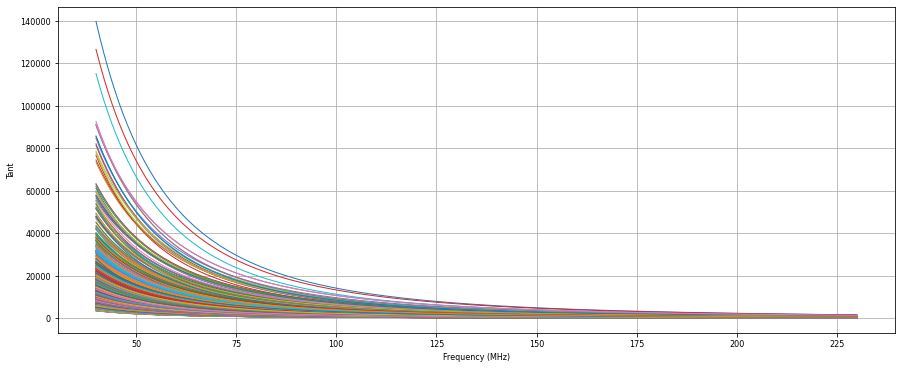

In [6]:
# Return value of polynomial
func_poly = lambda p, x    : (np.polyval(p,x))

plt.figure(figsize=[15,6])
plt.rcParams.update({'font.size': 8})
ax1=plt.subplot(1,1,1)
for i in range (len(spectrum)):
    #ax1.plot((freq_array),np.log10(spectrum[i]),"-", linewidth=1)    
    xx = (freq_array)
    yy = (spectrum[i])
    norder = 20
    zz = np.polyfit(np.log10(xx),np.log10(yy), norder)
    yy_fit = 10.0**( np.array(func_poly(zz,np.log10(xx))) )
    yy_res = yy - yy_fit
    ax1.plot((freq_array),yy,"-", linewidth=1) 
plt.ylabel('Tant')
plt.xlabel('Frequency (MHz)')
#plt.xlim([75,200])
#plt.ylim([0,500])
plt.grid()
plt.show()

fitting in index range:  1 43  and freq range:  41.0 83.0
0 64 0.03853503905884281
0 151 0.013680037971425918
0 396 0.025373684605483504
0 951 0.08246659965152503
0 1039 0.15066330139234196
0 1065 0.013536023941924213
0 1223 0.2804220634261583
0 1265 0.011586560446176009
0 1297 0.015580464578761166
0 1369 0.013738022362758784
0 1556 0.7153523992665214
0 1716 0.07439848957073991
0 2394 0.012215771126193431
fitting in index range:  18 75  and freq range:  58.0 115.0
1 396 0.027611358567355637
1 1175 0.26215752674033865
1 1265 0.029472985054326273
1 1297 0.01772998136084425
1 1369 0.01628754246621611
fitting in index range:  40 120  and freq range:  80.0 160.0
2 1175 0.2636649182513793
2 1265 0.025621546532875072
2 1369 0.01331913783269556
fitting in index range:  71 182  and freq range:  111.0 222.0
3 1189 0.016730344186953516


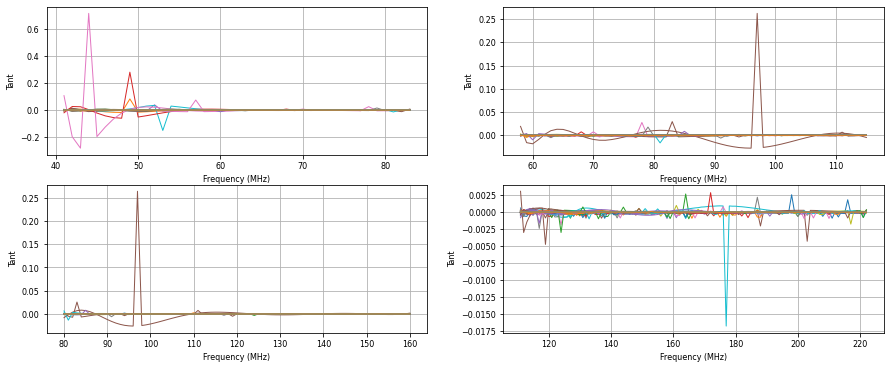

Indices to redo:  [  64  151  396  951 1039 1065 1175 1189 1223 1265 1297 1369 1556 1716
 2394]


In [7]:
## Fit in bands: 
band_definition = [[ 41.430528,  82.861056], \
       [ 57.5424  , 115.0848  ], \
       [ 79.92    , 159.84    ], \
       [111.      , 222.      ]]

plt.figure(figsize=[15,6])
plt.rcParams.update({'font.size': 8})

good_indices = np.ones(len(spectrum))

for iband in range (len(band_definition)):
    band_low = band_definition[iband][0]
    band_high = band_definition[iband][1]
    
    ax1=plt.subplot(2,2,iband+1)

    x00 = np.array(freq_array)
    ilow = np.argmin(np.abs(x00-band_low))
    ihigh = np.argmin(np.abs(x00-band_high))
    print("fitting in index range: ",ilow,ihigh," and freq range: ",freq_array[ilow],freq_array[ihigh])

    for i in range (len(spectrum)):
        xx = np.array(freq_array[ilow:ihigh+1])
        yy = np.array(spectrum[i][ilow:ihigh+1])
        norder = 10
        zz = np.polyfit(np.log10(xx),np.log10(yy), norder)
        yy_fit = 10.0**( np.array(func_poly(zz,np.log10(xx))) )
        yy_res = yy - yy_fit
        ax1.plot((xx),yy_res,"-", linewidth=1) 
        if np.max( np.abs(yy_res)) > 0.01 : 
            print(iband,i,np.max( np.abs(yy_res)))
            good_indices[i]=0
    plt.ylabel('Tant')
    plt.xlabel('Frequency (MHz)')
    plt.grid()
    
plt.show()

print("Indices to redo: ",np.where(good_indices == 0)[0])

In [8]:
#### write the array of GMOSS spectra into a pickle file
###
#fpkle = '/Users/sub005/Desktop/ginan/GMOSS_for_GINAN/GMOSS_spectra_v0.pkl'
#write_data = [freq_array,spectrum]
#pickle.dump(write_data,open(fpkle,'ab'),-1)

In [9]:
### Check that the file may be correctly read in and displayed
###
data1 = []
with (open(fpkle, "rb")) as pickle_file1:
    while True:
        try:
            data1.append(pickle.load(pickle_file1))
        except EOFError:
            break
pickle_file1.close()
ffreq = data1[0][0]
fspect = data1[0][1]
print("Data read: ",np.shape(ffreq),np.shape(fspect))

plt.figure(figsize=[15,6])
plt.rcParams.update({'font.size': 8})
ax1=plt.subplot(1,1,1)
for i in range (len(fspect)):
    ax1.plot((ffreq),fspect[i],"-", linewidth=1)    
plt.ylabel('Tant')
plt.xlabel('Frequency (MHz)')
#plt.ylim([0.0,500.0])
plt.grid()
plt.show()


NameError: name 'fpkle' is not defined